[Colab](https://colab.research.google.com/github/dominik-strutz/Endurance_CCS_design_study/blob/main/endurance_obs_optimisation.ipynb)

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! pip install --quiet zuko
        ! pip install --quiet cartopy
        ! pip install --quiet git+https://github.com/dominik-strutz/GeoBED.git@95f8416397dab58570c4e6c5de8b2e36613c5a57
        ! pip install --quiet ax-platform
        ! pip install --quiet pykonal


        # ! pip install --quiet obspy
        # clean up working directory
        ! rm -rf *

        ! git clone --quiet https://github.com/dominik-strutz/Endurance_CCS_design_study tmp
        ! mv tmp/* .
        ! rm -rf tmp
        dependencies_installed = True

In [2]:
import os
import torch.distributions as dist
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

from tqdm.autonotebook import tqdm

import cartopy.crs as ccrs
import xarray as xr

import cartopy.crs as ccrs
projPC = ccrs.PlateCarree()

/tmp/ipykernel_31877/2803177586.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from helpers import *

In [4]:
from geobed.core import BED_base_explicit

data_likelihood = Data_Likelihood(Forward_Class, 1.0, 0.02)

Test_BED = BED_base_explicit(
    data_likelihood_dist=data_likelihood,
    m_prior_dist=prior_dist,
    )

In [5]:
design_seis_only = seismic_inventory.to_numpy()
design_seis_only[:, :2] = seismic_stations_xy[:, :2]
design_seis_only = torch.from_numpy(design_seis_only).float()
# design_seis_only[:, 2] = -1 * design_seis_only[:, 2]

avg_surface_seis_noise = design_seis_only[:, -1].mean()
print(f'Average surface seismic noise: {avg_surface_seis_noise:.2f} s')


Average surface seismic noise: 0.90 s


In [6]:
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.utils.notebook.plotting import init_notebook_plotting, render

gs = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.SOBOL, 
            num_trials=50, 
            min_trials_observed=50, 
        ),
        GenerationStep(
            model=Models.GPEI,
            num_trials=-1,
            max_parallelism=10,  # Can set higher parallelism if needed
        )
    ]
)

ax_client = AxClient(verbose_logging=False, generation_strategy=gs)

x_min, x_max = topo_data_xy.coords['E'].values.min(), topo_data_xy.coords['E'].values.max()
y_min, y_max = topo_data_xy.coords['N'].values.min(), topo_data_xy.coords['N'].values.max()

ax_client.create_experiment(
    name="endurance_obs_sensors",
    parameters=[
        {'name': 'obs_1_x', 'type': 'range', 'value_type': 'float', 'bounds': [x_min, x_max]},
        {'name': 'obs_1_y', 'type': 'range', 'value_type': 'float', 'bounds': [y_min, y_max]},
    ],
    objective_name='EIG',
    # choose_generation_strategy_kwargs=
)

class Optimisation_Func:
    
    def __init__(self, BED, existing_design, topo_data_xy):
        self.BED = BED
        self.existing_design = existing_design
        self.topo_data_xy = topo_data_xy

    def __call__(self, input):
        obs_1_z = self.topo_data_xy.interp(E=input['obs_1_x'], N=input['obs_1_y'], method='linear').values    
        added_design = torch.from_numpy(np.array([[input['obs_1_x'], input['obs_1_y'], obs_1_z, avg_surface_seis_noise]]))
        design = torch.cat((self.existing_design, added_design), dim=0).float()
        
        EIG, _ = self.BED.calculate_EIG(
            design.unsqueeze(0),
            eig_method='dn',
            eig_method_kwargs={
                'N': int(1e4),
                },
            num_workers=1,
            random_seed=1,
            )
        
        return {'EIG': EIG.item()}


optimisation_func = Optimisation_Func(Test_BED, design_seis_only, topo_data_xy)

# n_trials = 100
n_trials = 100

for i in tqdm.tqdm(range(n_trials), total=n_trials, desc='Optimising OBS sensor'):
    parameters, trial_index = ax_client.get_next_trial()    
    # Local evaluation here can be replaced with deployment to external system.
    EIG_i = optimisation_func(parameters)
    ax_client.complete_trial(trial_index=trial_index, raw_data=EIG_i)

[INFO 11-08 17:17:22] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='obs_1_x', parameter_type=FLOAT, range=[0.0, 442298.90674426977]), RangeParameter(name='obs_1_y', parameter_type=FLOAT, range=[0.0, 445008.4159561554])], parameter_constraints=[]).
Optimising OBS sensor: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


In [7]:
optimal_obs = ax_client.get_best_parameters()[0]

obs_1_z = topo_data_xy.interp(E=optimal_obs['obs_1_x'], N=optimal_obs['obs_1_y'], method='linear').values    
optimal_obs = torch.from_numpy(np.array([[optimal_obs['obs_1_x'], optimal_obs['obs_1_y'], obs_1_z, 0.5]]))
optimal_design = torch.cat((design_seis_only, optimal_obs), dim=0).float()

In [8]:
render(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG"))

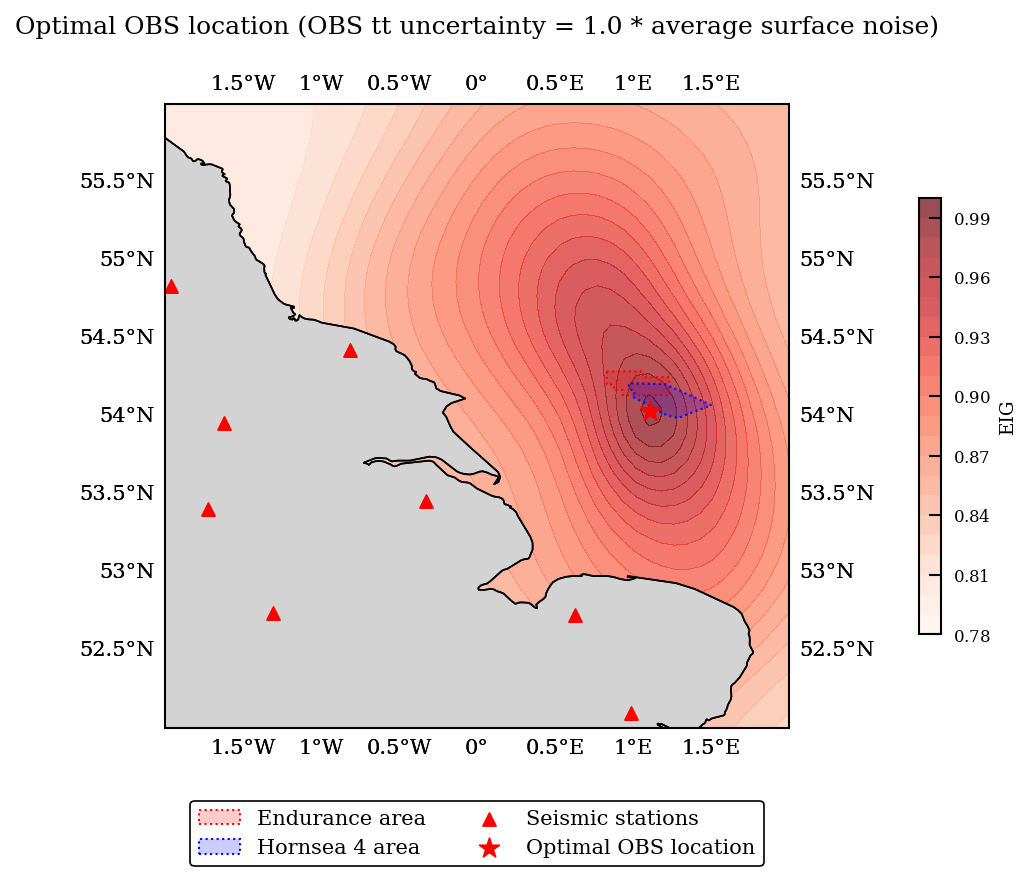

In [9]:

x = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['x'])
y = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['y'])
EIG = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['z'])

y_latlon, x_latlon = xy2latlong(x, y, topo_data_xy, topo_data_latlon)

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(projection=projPC))

plot_geographic_settings(
    ax, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX,
    landmarks_df, endurance_area_latlon, hornsea_4_latlon,
    seismic_inventory, projPC,
    # add_mine=boulby_mine_latlon,
    add_land=False, add_cities=False)

cont = ax.contourf(x_latlon, y_latlon, EIG, levels=20, cmap='Reds', alpha=0.7, zorder=-2,)

od_lat, od_lon = xy2latlong(optimal_design[:, 0].numpy(), optimal_design[:, 1].numpy(), topo_data_xy, topo_data_latlon)
ax.scatter(od_lon[-1], od_lat[-1], marker='*', s=100, color='red', zorder=10, label='Optimal OBS location')

ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, alpha=0.0)

ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=-1, edgecolor='k', facecolor='lightgrey')
fig.colorbar(cont, label='EIG', shrink=0.7, ax=ax, pad=0.1,)

# place legend below plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=10)

ax.set_title(f'Optimal OBS location (OBS tt uncertainty = 1.0 * average surface noise)', fontsize=12, pad=20)

ax.set_aspect('equal')

plt.tight_layout()

plt.show()

In [11]:
true_event = torch.tensor([335.0, 245.0, -1.02]) *1e3
true_depth = true_event[2]

N_grid_posterior = 50

local_x_min, local_x_max = 315_000, 350_000
local_y_min, local_y_max = 235_000, 260_000
local_z_min, local_z_max = -3_000, 0

x_local = torch.linspace(local_x_min, local_x_max, N_grid_posterior)
y_local = torch.linspace(local_y_min, local_y_max, N_grid_posterior)
z_local = torch.linspace(local_z_min, local_z_max, N_grid_posterior)

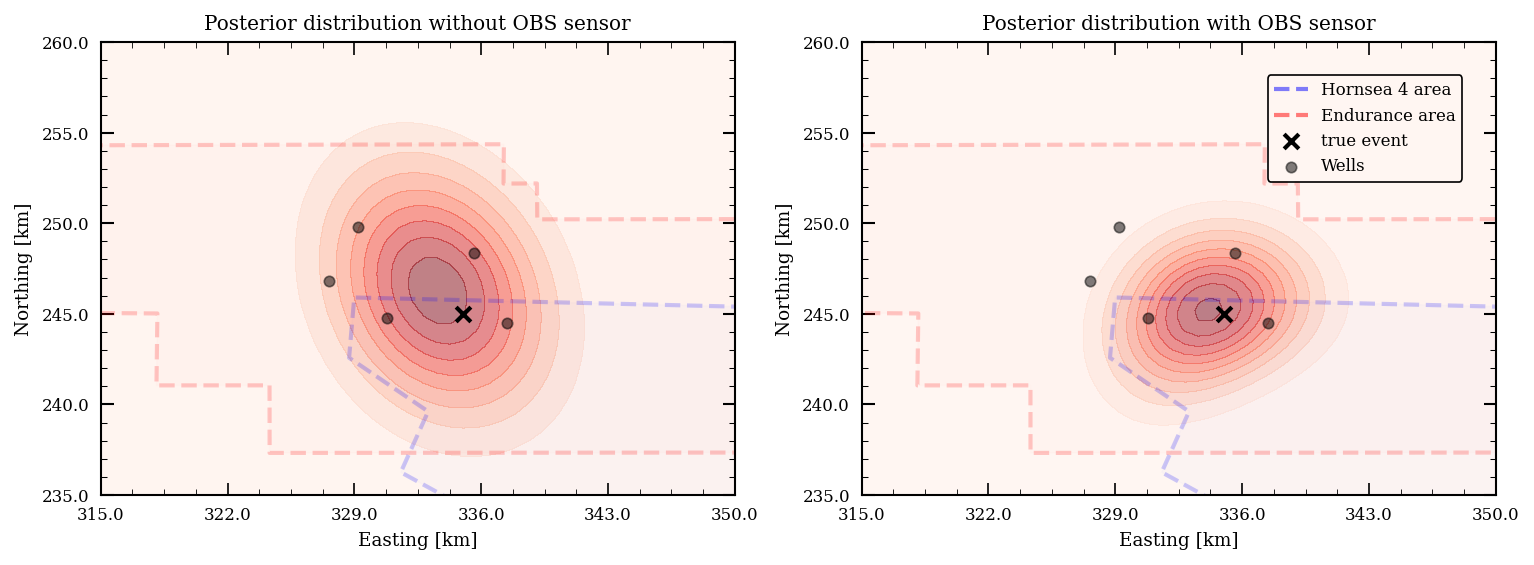

In [12]:
fig, ax_dict = plt.subplot_mosaic([['a', 'b']], figsize=(12, 6))

ax = ax_dict['a']

tt_obs = Forward_Class(design_seis_only, true_event[None, :]).squeeze()

p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = gridsearch_posterior(tt_obs, x_local, y_local, z_local, design_seis_only, prior_dist, data_likelihood) 

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local,
    slice_axis='z', slice_value=true_depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,
    )

ax.get_legend().remove()

ax.set_title(f'Posterior distribution without OBS sensor')


ax = ax_dict['b']

tt_obs = Forward_Class(optimal_design, true_event[None, :]).squeeze()

p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = gridsearch_posterior(tt_obs, x_local, y_local, z_local, optimal_design, prior_dist, data_likelihood)

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='z', slice_value=true_depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,)

ax.set_title(f'Posterior distribution with OBS sensor')


plt.show()

# Lower Noise Level

In [15]:
gs = GenerationStrategy(
    steps=[
        GenerationStep(
            model=Models.SOBOL, 
            num_trials=30, 
            min_trials_observed=30, 
        ),
        GenerationStep(
            model=Models.GPEI,
            num_trials=-1,
            max_parallelism=10,  # Can set higher parallelism if needed
        )
    ]
)

ax_client = AxClient(verbose_logging=False, generation_strategy=gs)

x_min, x_max = topo_data_xy.coords['E'].values.min(), topo_data_xy.coords['E'].values.max()
y_min, y_max = topo_data_xy.coords['N'].values.min(), topo_data_xy.coords['N'].values.max()

ax_client.create_experiment(
    name="endurance_obs_sensors",
    parameters=[
        {'name': 'obs_1_x', 'type': 'range', 'value_type': 'float', 'bounds': [x_min, x_max]},
        {'name': 'obs_1_y', 'type': 'range', 'value_type': 'float', 'bounds': [y_min, y_max]},
    ],
    objective_name='EIG',
    # choose_generation_strategy_kwargs=
)

class Optimisation_Func:
    
    def __init__(self, BED, existing_design, topo_data_xy):
        self.BED = BED
        self.existing_design = existing_design
        self.topo_data_xy = topo_data_xy

    def __call__(self, input):
        obs_1_z = self.topo_data_xy.interp(E=input['obs_1_x'], N=input['obs_1_y'], method='linear').values    
        added_design = torch.from_numpy(np.array([[input['obs_1_x'], input['obs_1_y'], obs_1_z, avg_surface_seis_noise*0.1]]))
        design = torch.cat((self.existing_design, added_design), dim=0).float()
        
        EIG, _ = self.BED.calculate_EIG(
            design.unsqueeze(0),
            eig_method='dn',
            eig_method_kwargs={
                'N': int(1e4),
                },
            num_workers=1,
            random_seed=1,
            )
        
        return {'EIG': EIG.item()}


optimisation_func = Optimisation_Func(Test_BED, design_seis_only, topo_data_xy)

n_trials = 50

for i in tqdm.tqdm(range(n_trials), total=n_trials, desc='Optimising OBS sensor'):
    parameters, trial_index = ax_client.get_next_trial()    
    # Local evaluation here can be replaced with deployment to external system.
    EIG_i = optimisation_func(parameters)
    ax_client.complete_trial(trial_index=trial_index, raw_data=EIG_i)

[INFO 11-08 17:19:02] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='obs_1_x', parameter_type=FLOAT, range=[0.0, 442298.90674426977]), RangeParameter(name='obs_1_y', parameter_type=FLOAT, range=[0.0, 445008.4159561554])], parameter_constraints=[]).
Optimising OBS sensor: 100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


In [16]:
optimal_obs = ax_client.get_best_parameters()[0]

obs_1_z = topo_data_xy.interp(E=optimal_obs['obs_1_x'], N=optimal_obs['obs_1_y'], method='linear').values    
optimal_obs = torch.from_numpy(np.array([[optimal_obs['obs_1_x'], optimal_obs['obs_1_y'], obs_1_z, 0.5]]))
optimal_design = torch.cat((design_seis_only, optimal_obs), dim=0).float()

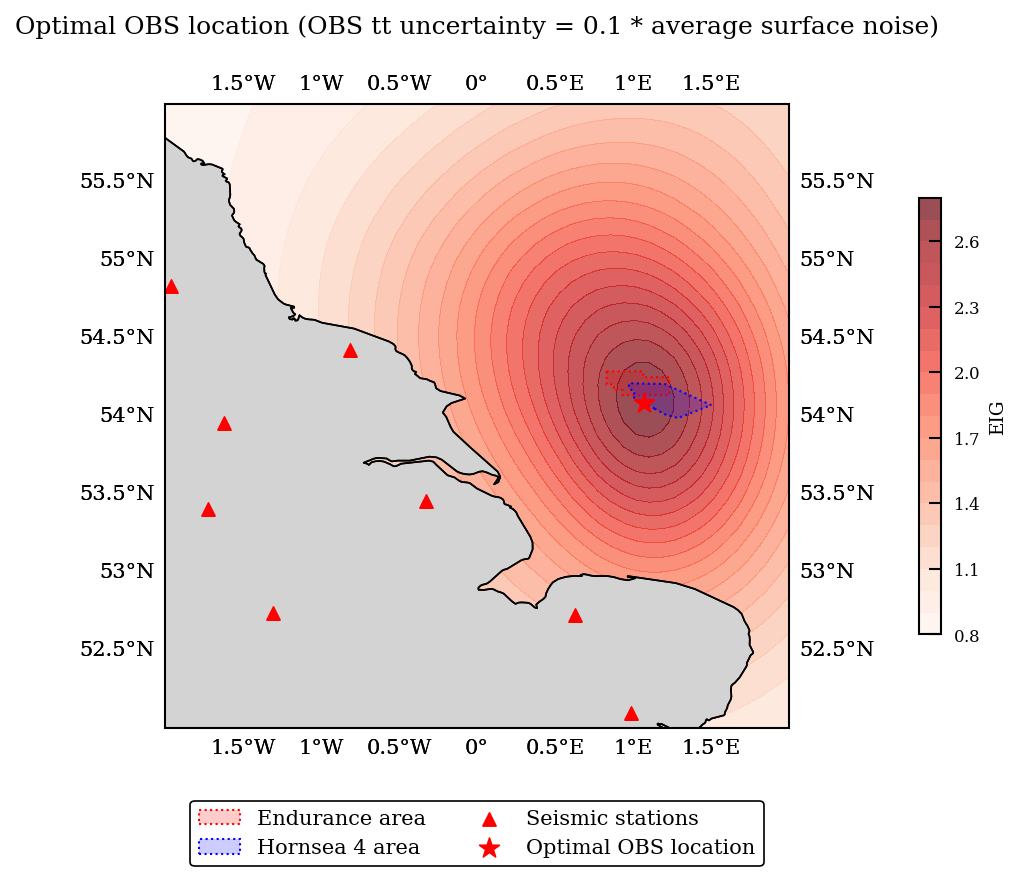

In [19]:
x = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['x'])
y = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['y'])
EIG = np.array(ax_client.get_contour_plot(param_x="obs_1_x", param_y="obs_1_y", metric_name="EIG").data['data'][0]['z'])

y_latlon, x_latlon = xy2latlong(x, y, topo_data_xy, topo_data_latlon)

fig, ax = plt.subplots(figsize=(9, 6), subplot_kw=dict(projection=projPC))

# im = xr.plot.imshow(
#     topo_data_xy, cmap='Greys', x='E', y='N', #xlim=(local_lon_min, local_lon_max), ylim=(local_lat_min, local_lat_max),
#     vmin=-3, vmax=-2, alpha=1.0, zorder=1,
#     add_colorbar=False)

plot_geographic_settings(
    ax, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX,
    landmarks_df, endurance_area_latlon, hornsea_4_latlon,
    seismic_inventory, projPC,
    add_land=False, add_cities=False)

cont = ax.contourf(x_latlon, y_latlon, EIG, levels=20, cmap='Reds', alpha=0.7, zorder=-2,)

od_lat, od_lon = xy2latlong(optimal_design[:, 0].numpy(), optimal_design[:, 1].numpy(), topo_data_xy, topo_data_latlon)
ax.scatter(od_lon[-1], od_lat[-1], marker='*', s=100, color='red', zorder=10, label='Optimal OBS location')

ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, alpha=0.0)

ax.coastlines()

ax.add_feature(cartopy.feature.LAND, zorder=-1, edgecolor='k', facecolor='lightgrey')
fig.colorbar(cont, label='EIG', shrink=0.7, ax=ax, pad=0.1,)

# place legend below plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=10)

ax.set_title(f'Optimal OBS location (OBS tt uncertainty = 0.1 * average surface noise)', fontsize=12, pad=20)

ax.set_aspect('equal')

plt.tight_layout()

plt.show()

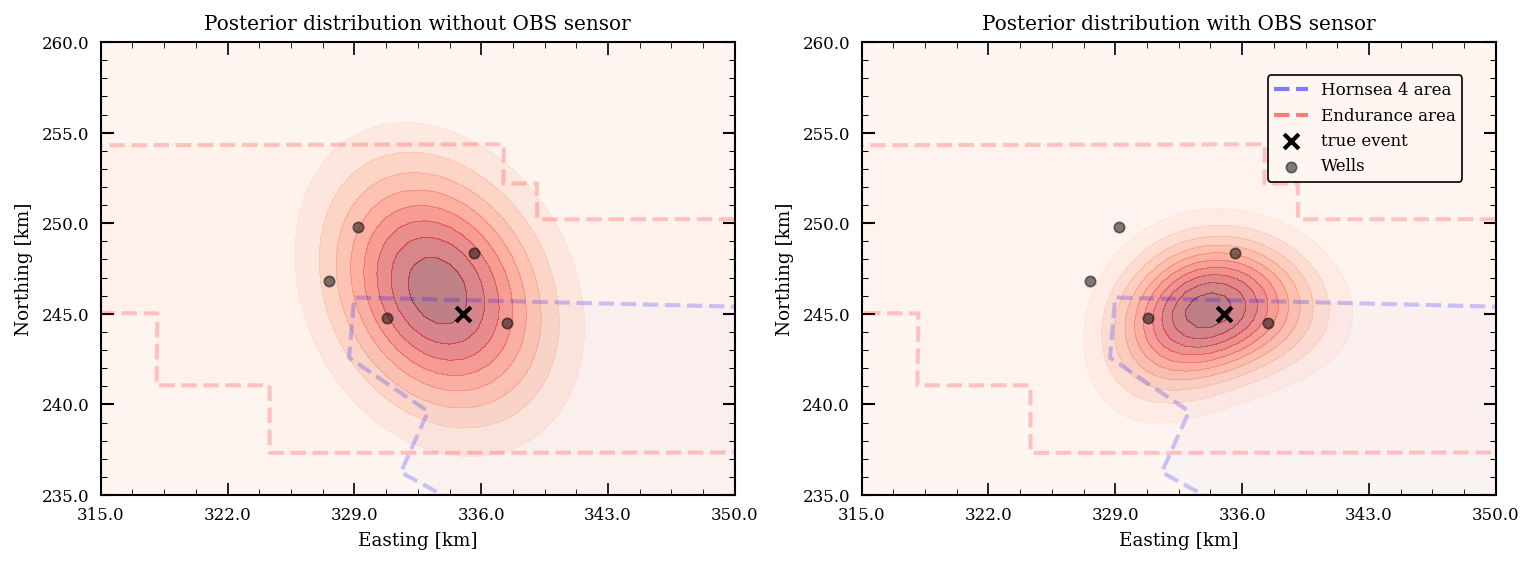

In [21]:
fig, ax_dict = plt.subplot_mosaic([['a', 'b']], figsize=(12, 6))

ax = ax_dict['a']

tt_obs = Forward_Class(design_seis_only, true_event[None, :]).squeeze()

p_posterior_no_obs, p_prior_no_obs, p_posterior_X_no_obs, p_posterior_Y_no_obs, p_posterior_Z_no_obs = gridsearch_posterior(tt_obs, x_local, y_local, z_local, design_seis_only, prior_dist, data_likelihood) 

plot_modelspace_dist_slice(
    ax, p_posterior_no_obs, p_posterior_X_no_obs, p_posterior_Y_no_obs, p_posterior_Z_no_obs,
    x_local, y_local, z_local,
    slice_axis='z', slice_value=true_depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,
    )

ax.get_legend().remove()

ax.set_title(f'Posterior distribution without OBS sensor')


ax = ax_dict['b']

tt_obs = Forward_Class(true_event[None, :], optimal_design).squeeze()

p_posterior, p_prior, p_posterior_X, p_posterior_Y, p_posterior_Z = gridsearch_posterior(tt_obs, x_local, y_local, z_local, optimal_design, prior_dist, data_likelihood)

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='z', slice_value=true_depth,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.5, 'zorder': 0},
    hornsea = hornsea_4_xy,
    endurance = endurance_area_xy,
    wells=wells_coords_xy,
    true_event=true_event,)

ax.set_title(f'Posterior distribution with OBS sensor')


plt.show()

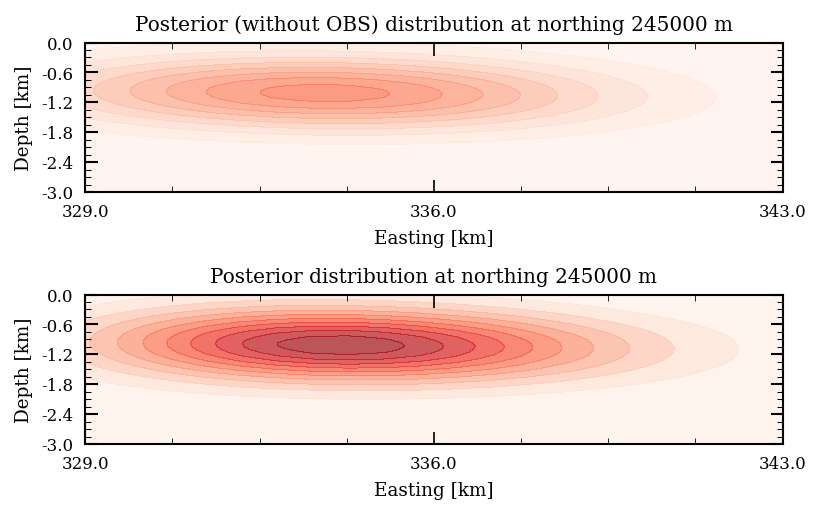

In [22]:
N_slice = true_event[1]

fig, ax_dict = plt.subplot_mosaic([['a'],['b']], figsize=(6, 4))

ax = ax_dict['a']

plot_modelspace_dist_slice(
    ax, p_posterior_no_obs, p_posterior_X_no_obs, p_posterior_Y_no_obs, p_posterior_Z_no_obs,
    x_local, y_local, z_local,
    slice_axis='N', slice_value=N_slice,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.7, 'zorder': 0,
                    'vmin': p_posterior.min().exp()*0.9,
                    'vmax': p_posterior.max().exp()*1.1},)

ax.set_title(f'Posterior (without OBS) distribution at northing {N_slice:.0f} m')

ax = ax_dict['b']

plot_modelspace_dist_slice(
    ax, p_posterior, p_posterior_X, p_posterior_Y, p_posterior_Z,
    x_local, y_local, z_local, 
    slice_axis='N', slice_value=N_slice,
    contour_kwargs={'levels': 10, 'cmap': 'Reds', 'alpha': 0.7, 'zorder': 0,
                    'vmin': p_posterior.min().exp()*0.9,
                    'vmax': p_posterior.max().exp()*1.1},)

ax.set_title(f'Posterior distribution at northing {N_slice:.0f} m')

for ax in ax_dict.values():
    ax.set_xlim(329e3, 343e3)


plt.show()